In [1]:
cd ..

/home/araxal/coursework


In [2]:
from utils.instrument_recognition import feature_preparator
from models.instrument_recognition.FeedForwardSimpleModel1D import FeedForwardSimpleModel1D
import numpy as np
import torch
from utils.instrument_recognition import executor
from utils.instrument_recognition import plot_metrics
from utils.instrument_recognition import evaluate
from torch import nn
from utils.instrument_recognition import plot_confusion_matrix
from sklearn.metrics import classification_report
from utils.instrument_recognition import calculate_accuracy
from utils.instrument_recognition import squeeze_answer_matrix, get_exact_match_ratio, get_accuracy
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utils.instrument_recognition.evaluate_multilabel import evaluate_multilabel

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
BATCH_SIZE = 8
DEVICE = torch.device('cuda')

In [5]:
dataloaders, idx_to_instrument, instrument_to_idx, shapes = feature_preparator(BATCH_SIZE, transform = lambda x: np.mean(x, axis = 0))

In [6]:
train, val, test = dataloaders['accordion']

In [7]:
z = next(iter(train))
x = next(iter(val))
c = next(iter(test))

print(z[0].shape, z[1].shape, z[2].shape)
print(x[0].shape, x[1].shape, x[2].shape)
print(c[0].shape, c[1].shape, c[2].shape)
print(shapes)

torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
(14915, 2034, 3051)


 28%|██▊       | 28/100 [00:11<00:28,  2.54it/s]

Early stop!


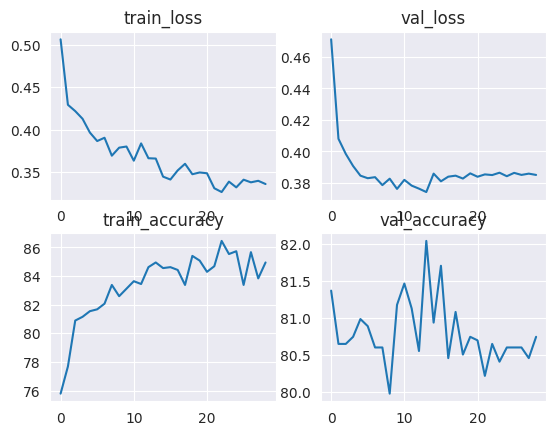

In [7]:
ff_simple_model = FeedForwardSimpleModel1D(128).to(DEVICE)
train_progress, val_progress = executor(
    DEVICE,
    ff_simple_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=20,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.86      0.91      0.89       225
        True       0.66      0.54      0.59        71

    accuracy                           0.82       296
   macro avg       0.76      0.72      0.74       296
weighted avg       0.81      0.82      0.81       296



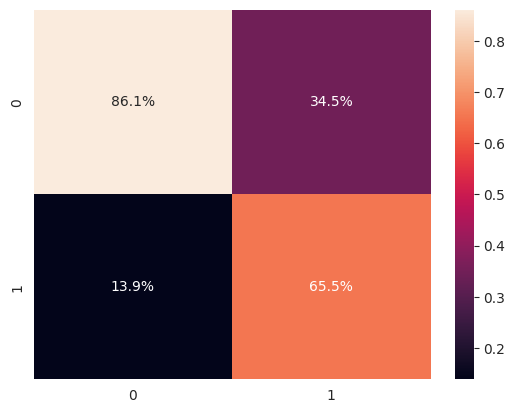

In [8]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_simple_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

In [8]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = FeedForwardSimpleModel1D(128).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=100,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 20%|██        | 20/100 [00:07<00:31,  2.56it/s]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.87      0.93      0.90       227
        True       0.69      0.55      0.61        69

    accuracy                           0.84       296
   macro avg       0.78      0.74      0.76       296
weighted avg       0.83      0.84      0.83       296



 17%|█▋        | 17/100 [00:06<00:33,  2.46it/s]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.82      0.85      0.84       187
        True       0.65      0.60      0.62        85

    accuracy                           0.77       272
   macro avg       0.73      0.73      0.73       272
weighted avg       0.77      0.77      0.77       272



 31%|███       | 31/100 [00:09<00:21,  3.21it/s]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.90      0.94      0.92       220
        True       0.73      0.62      0.67        60

    accuracy                           0.87       280
   macro avg       0.81      0.78      0.79       280
weighted avg       0.86      0.87      0.86       280



 21%|██        | 21/100 [00:06<00:26,  3.03it/s]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.80      0.79      0.80       150
        True       0.80      0.81      0.81       154

    accuracy                           0.80       304
   macro avg       0.80      0.80      0.80       304
weighted avg       0.80      0.80      0.80       304



 26%|██▌       | 26/100 [00:11<00:32,  2.27it/s]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.81      0.92      0.86       306
        True       0.47      0.23      0.31        86

    accuracy                           0.77       392
   macro avg       0.64      0.58      0.59       392
weighted avg       0.74      0.77      0.74       392



 45%|████▌     | 45/100 [00:13<00:16,  3.27it/s]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.93      0.87      0.90        82
        True       0.94      0.97      0.95       174

    accuracy                           0.94       256
   macro avg       0.94      0.92      0.93       256
weighted avg       0.94      0.94      0.94       256



 30%|███       | 30/100 [00:09<00:22,  3.18it/s]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.93      0.86      0.89        97
        True       0.91      0.96      0.94       151

    accuracy                           0.92       248
   macro avg       0.92      0.91      0.91       248
weighted avg       0.92      0.92      0.92       248



 30%|███       | 30/100 [00:10<00:24,  2.89it/s]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.77      0.88      0.82       226
        True       0.66      0.45      0.54       110

    accuracy                           0.74       336
   macro avg       0.71      0.67      0.68       336
weighted avg       0.73      0.74      0.73       336



 56%|█████▌    | 56/100 [00:13<00:10,  4.03it/s]


Early stop!
----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.93      0.90      0.91        98
        True       0.94      0.96      0.95       166

    accuracy                           0.94       264
   macro avg       0.93      0.93      0.93       264
weighted avg       0.94      0.94      0.94       264



 34%|███▍      | 34/100 [00:10<00:20,  3.17it/s]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.80      0.75      0.77       170
        True       0.67      0.74      0.70       118

    accuracy                           0.74       288
   macro avg       0.74      0.74      0.74       288
weighted avg       0.75      0.74      0.74       288



 20%|██        | 20/100 [00:09<00:37,  2.14it/s]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.86      0.80      0.83       244
        True       0.63      0.72      0.67       116

    accuracy                           0.77       360
   macro avg       0.74      0.76      0.75       360
weighted avg       0.78      0.77      0.78       360



 17%|█▋        | 17/100 [00:05<00:26,  3.09it/s]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.77      0.90      0.83       189
        True       0.63      0.39      0.48        83

    accuracy                           0.74       272
   macro avg       0.70      0.64      0.65       272
weighted avg       0.73      0.74      0.72       272



 23%|██▎       | 23/100 [00:07<00:23,  3.21it/s]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.98      0.87      0.92        70
        True       0.96      0.99      0.97       194

    accuracy                           0.96       264
   macro avg       0.97      0.93      0.95       264
weighted avg       0.96      0.96      0.96       264



 29%|██▉       | 29/100 [00:14<00:36,  1.94it/s]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.88      0.76      0.82       190
        True       0.77      0.89      0.83       170

    accuracy                           0.82       360
   macro avg       0.83      0.83      0.82       360
weighted avg       0.83      0.82      0.82       360



 28%|██▊       | 28/100 [00:08<00:21,  3.42it/s]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.92      0.87      0.89        53
        True       0.96      0.97      0.96       155

    accuracy                           0.95       208
   macro avg       0.94      0.92      0.93       208
weighted avg       0.95      0.95      0.95       208



 33%|███▎      | 33/100 [00:18<00:38,  1.76it/s]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.86      0.90      0.88       293
        True       0.67      0.57      0.61        99

    accuracy                           0.82       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.81      0.82      0.81       392



 27%|██▋       | 27/100 [00:16<00:45,  1.62it/s]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.82      0.85      0.83       290
        True       0.69      0.63      0.66       150

    accuracy                           0.78       440
   macro avg       0.75      0.74      0.75       440
weighted avg       0.77      0.78      0.77       440



 51%|█████     | 51/100 [00:23<00:22,  2.20it/s]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.84      0.87      0.85       246
        True       0.70      0.63      0.66       114

    accuracy                           0.80       360
   macro avg       0.77      0.75      0.76       360
weighted avg       0.79      0.80      0.79       360



 40%|████      | 40/100 [00:14<00:21,  2.82it/s]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.73      0.74      0.73       121
        True       0.88      0.88      0.88       279

    accuracy                           0.84       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.84      0.84      0.84       400



 30%|███       | 30/100 [00:07<00:18,  3.85it/s]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.91      0.88      0.89        96
        True       0.90      0.93      0.91       112

    accuracy                           0.90       208
   macro avg       0.90      0.90      0.90       208
weighted avg       0.90      0.90      0.90       208



In [9]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

INSTRUMENT MACRO ACCURACY: 82.69400024414062


''

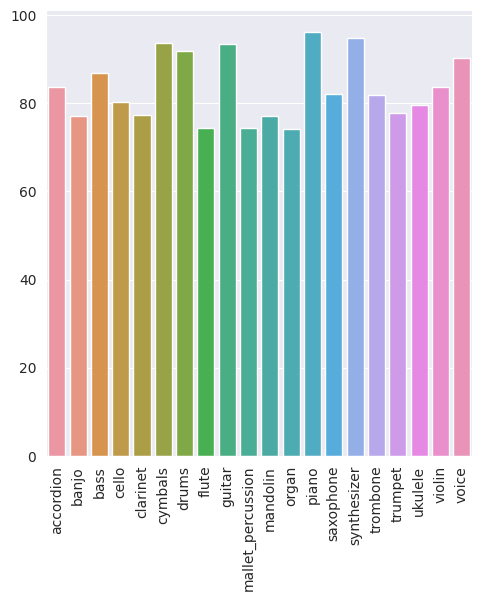

In [10]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [11]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TEST
Exact Match Ratio 0.7027204195345789
Accuracy 0.7519665683382496


In [17]:
for key, value in models.items():
    torch.save(value.state_dict(), f'instrument_classification_models/{key}')